### Load data and build matrices

In [1]:
cd ../../../../

/Users/archnnj/Development/recsys/recsys_polimi_challenge_2018/repo


In [2]:
%load_ext autoreload
%autoreload 2

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
%matplotlib inline
import scipy.sparse as sps
from scipy.stats import iqr
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":12,"axes.titlesize":12,"axes.labelsize":12})

import src.utils.build_icm as build_icm
from src.utils.data_splitter import train_test_holdout, train_test_user_holdout, train_test_row_holdout

import time

In [4]:
import sys
sys.path.append("src/libs/RecSys_Course_2018/") # go to parent dir
sys.path.append("src/libs/RecSys_Course_2018/SequenceAware/sars_tutorial_master/") # go to parent dir

In [5]:
from src.recommenders.HybridLinCombEstRatings import HybridLinCombEstRatings

#### Global vars

In [6]:
JUPYTER = False

#### Load data

In [7]:
if JUPYTER:
    # Jupyter
    tracks_csv_file = "../../../data/tracks.csv"
    interactions_csv_file = "../../../data/train.csv"
    playlist_id_csv_file = "../../../data/target_playlists.csv"
    sequential_csv_file = "../../../data/train_sequential.csv"
else:
    # PyCharm
    tracks_csv_file = "data/tracks.csv"
    interactions_csv_file = "data/train.csv"
    playlist_id_csv_file = "data/target_playlists.csv"
    sequential_csv_file = "data/train_sequential.csv"

tracks_df = pd.read_csv(tracks_csv_file)
interactions_df = pd.read_csv(interactions_csv_file)
playlist_id_df = pd.read_csv(playlist_id_csv_file)
train_sequential_df = pd.read_csv(sequential_csv_file)

userList = interactions_df["playlist_id"]
itemList = interactions_df["track_id"]
ratingList = np.ones(interactions_df.shape[0])
targetsList = playlist_id_df["playlist_id"]
targetsListList = targetsList.tolist()
targetsListOrdered = targetsList[:5000].tolist()
targetsListCasual = targetsList[5000:].tolist()

userList_unique = pd.unique(userList)
itemList_unique = tracks_df["track_id"]
numUsers = len(userList_unique)
numItems = len(itemList_unique)
numberInteractions = interactions_df.size

In [8]:
URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all_csr = URM_all.tocsr()

In [9]:
itemPopularity = (URM_all>0).sum(axis=0)
itemPopularity = np.array(itemPopularity).squeeze()
itemPopularity_unsorted = itemPopularity
itemPopularity = np.sort(itemPopularity)

#### Prepare ICM and URM with splits

In [115]:
# Build ICM
ICM_all = build_icm.build_icm(tracks_df, split_duration_lenght=800, feature_weights={'albums': 1, 'artists': 0.5, 'durations': 0.1})

IDF_ENABLED = True

if IDF_ENABLED:
    num_tot_items = ICM_all.shape[0]
    # let's count how many items have a certain feature
    items_per_feature = (ICM_all > 0).sum(axis=0)
    IDF = np.array(np.log(num_tot_items / items_per_feature))[0]
    ICM_idf = ICM_all.copy()
    # compute the number of non-zeros in each col
    # NOTE: this works only if X is instance of sparse.csc_matrix
    col_nnz = np.diff(sps.csc_matrix(ICM_idf).indptr)
    # then normalize the values in each col
    ICM_idf.data *= np.repeat(IDF, col_nnz)
    ICM_all = ICM_idf  # use IDF features

# #### Build URM

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all_csr = URM_all.tocsr()

URM_IDF_ENABLED = False

if URM_IDF_ENABLED:
    num_tot_items = URM_all.shape[0]
    # let's count how many items have a certain feature
    items_per_feature = (URM_all > 0).sum(axis=0)
    IDF = np.array(np.log(num_tot_items / items_per_feature))[0]
    URM_idf = URM_all.copy()
    # compute the number of non-zeros in each col
    # NOTE: this works only if X is instance of sparse.csc_matrix
    col_nnz = np.diff(sps.csc_matrix(URM_idf).indptr)
    # then normalize the values in each col
    URM_idf.data *= np.repeat(IDF, col_nnz)
    URM_all = URM_idf  # use IDF features

# #### Train/test split: ratings and user holdout

seed = 0
# ratings holdout
# URM_train, URM_test_pred = train_test_holdout(URM_all, train_perc=0.8, seed=seed)
# URM_valid=URM_test_pred
# URM_test_known = None

# user holdout
# URM_train, URM_test_known, URM_test_pred = train_test_user_holdout(URM_all, user_perc=0.8, train_perc=0.8, seed=seed)

# row holdout
#URM_train, URM_test_pred = train_test_row_holdout(URM_all, userList_unique, train_sequential_df, train_perc=0.8, seed=seed, targetsListOrdered=targetsListOrdered, nnz_threshold=10)
#URM_test_known = None
URM_train, URM_test_pred = train_test_row_holdout(URM_all, targetsListOrdered, train_sequential_df,
                                                        train_perc=0.8,
                                                        seed=seed, targetsListOrdered=targetsListOrdered,
                                                        nnz_threshold=2)

# row holdout - validation
# URM_train_val, URM_test_pred = train_test_row_holdout(URM_all, userList_unique, train_sequential_df, train_perc=0.8,
#                                                       seed=seed, targetsListOrdered=targetsListOrdered,
#                                                       nnz_threshold=10)
# URM_train, URM_valid = train_test_holdout(URM_train_val, train_perc=0.7, seed=seed)
# URM_test_known = None
# URM_train, URM_valid_test_pred = train_test_row_holdout(URM_all, userList_unique, train_sequential_df,
#                                                        train_perc=0.6,
#                                                        seed=seed, targetsListOrdered=targetsListOrdered,
#                                                        nnz_threshold=2)
# URM_valid, URM_test_pred = train_test_row_holdout(URM_valid_test_pred, userList_unique, train_sequential_df,
#                                                   train_perc=0.5,
#                                                  seed=seed, targetsListOrdered=targetsListOrdered,
#                                                  nnz_threshold=1)

URM_train = URM_train
#URM_validation = URM_valid
URM_test = URM_test_pred

#### Utils

In [11]:
def get_sequences_df(URM, train_sequential_df, user_arr):
    sequences_arr = []
    for user_id in user_arr:
        URM_start_pos = URM.indptr[user_id]
        URM_end_pos = URM.indptr[user_id + 1]
        user_nnz = URM_end_pos - URM_start_pos
        
        if user_nnz > 0:
            original_order_items = np.array(
                train_sequential_df.loc[train_sequential_df['playlist_id'].isin([user_id])]['track_id'])
            original_order_items = np.array([i for i in original_order_items if i in URM.indices[URM_start_pos:URM_end_pos]]) # filter items in urm
            # original_order_items_sorted_i = original_order_items.argsort()
            original_order_items = original_order_items.tolist()
            for i in range(len(original_order_items)):
                item = original_order_items[i]
                sequences_arr.append({'pid':user_id, 'tid': item, 'pos': i})
    sequences = pd.DataFrame(sequences_arr)
    # sequences = sequences[['user_id', 'sequence']]
    return sequences

#### Create Sequence

In [116]:
sequences = get_sequences_df(URM_all.tocsr(), train_sequential_df, targetsListOrdered)
train_sequences = get_sequences_df(URM_train, train_sequential_df, targetsListOrdered)
test_sequences = get_sequences_df(URM_test, train_sequential_df, targetsListOrdered)

In [13]:
sequences.head()

,pid,pos,tid
0,7,0,12493
1,7,1,17495
2,7,2,13424
3,7,3,7109
4,7,4,14714


In [14]:
train_sequences.head()

,pid,pos,tid
0,7,0,12493
1,7,1,17495
2,7,2,13424
3,7,3,7109
4,7,4,14714


In [15]:
test_sequences.head()

,pid,pos,tid
0,7,0,8869
1,7,1,13359
2,7,2,15296
3,7,3,17114
4,7,4,3767


#### Evaluation setup

In [17]:
users_excluded_targets_for_cas = [u for u in userList_unique if u not in targetsListCasual]

In [117]:
users_excluded_targets_for_seq = [u for u in userList_unique if u not in targetsListOrdered]

In [19]:
users_excluded_targets_for_tot = [u for u in userList_unique if u not in targetsListList]

In [20]:
from Base.Evaluation.Evaluator import SequentialEvaluator, CompleteEvaluator, FastEvaluator

evaluator_test_casual = FastEvaluator(URM_test, cutoff_list=[10], minRatingsPerUser=1, exclude_seen=True, ignore_users=users_excluded_targets_for_cas)

Ignoring 45446 Users


In [118]:
from Base.Evaluation.Evaluator import SequentialEvaluator, CompleteEvaluator, FastEvaluator

evaluator_test_seq = FastEvaluator(URM_test, cutoff_list=[10], minRatingsPerUser=1, exclude_seen=True, ignore_users=users_excluded_targets_for_seq)

Ignoring 45446 Users


In [22]:
from Base.Evaluation.Evaluator import SequentialEvaluator, CompleteEvaluator, FastEvaluator

evaluator_test_tot = FastEvaluator(URM_test, cutoff_list=[10], minRatingsPerUser=1, exclude_seen=True, ignore_users=users_excluded_targets_for_tot)

Ignoring 40446 Users


#### Load estimate ratings

In [119]:
import pickle

#with open("dump/dump_est_rat_tot_array_complete", "rb") as dump_file:
#    recsys_est_ratings = pickle.load(dump_file)
with open("dump/dump_est_rat_seq_sum_train0802th2", "rb") as dump_file:
    total_est_ratings = pickle.load(dump_file)

In [139]:
total_est_ratings.min(), total_est_ratings.max(), total_est_ratings.mean()

(0.0, 2763.6292, 1.0019466)

Text(0.5, 1.0, 'Distribution and Density of Duration (100 bins)')

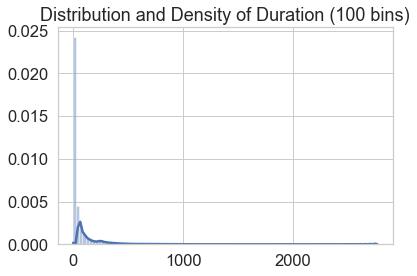

In [146]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
dp = sns.distplot(total_est_ratings.data,bins=100)
dp.set_title('Distribution and Density of Duration (100 bins)')

#### Boosting

In [33]:
import src.utils.similarity_wrapper as sim
sim_k = 100
sim_shrinkage = 1
sim_type = "cosine"
sim_alpha = -1
sim_beta = -1
sim_threshold = 0
similarity = sim.compute_similarity(type=sim_type, matrix=URM_train.T, k=sim_k, shrink=sim_shrinkage,
                                    alpha=sim_alpha, beta=sim_beta, threshold=sim_threshold)
similarity = similarity.T.tocsr()

In [55]:
sys.path.append("src/libs/spotify_recsys_challenge_master/") # go to parent dir
from utils.pre_processing import * # norms

#### HoleBoost / GapBoost (not working for us)

#### HeteroBoost

In [39]:
from src.libs.spotify_recsys_challenge_master.boosts.hetero_boost import HeteroBoost
hetb = HeteroBoost(train_sequences, tracks_df, total_est_ratings, URM_train, norm=norm_l1_row)

In [40]:
longTh = 25
targetsListOrderedLong = [u for u in targetsListOrdered if URM_train[u].nnz >= longTh]

In [43]:
# eurm_boosted = hetb.boost_eurm(playlists_indices_to_boost=targetsListOrderedLong, gamma=0.5) # NOT GOOD

HeteroBoost: 100%|██████████| 1213/1213 [00:00<00:00, 18751.90it/s]


#### TailBoost

In [51]:
from src.libs.spotify_recsys_challenge_master.boosts.tail_boost import TailBoost
tb = TailBoost(test_sequences, total_est_ratings, similarity, norm=norm_l2_row)

In [52]:
last_tracks = 1 # [10, 3, 3, 3]
k= 158 # [100, 80, 100, 100]
gamma= 0.001567686896365356 # [0.01, 0.01, 0.01, 0.01]
eurm_boosted = tb.boost_eurm(targetsListOrdered, last_tracks, k, gamma)

TailBoost: 100%|██████████| 5000/5000 [00:05<00:00, 965.18it/s] 


#### AlbumBoost

In [92]:
from src.libs.spotify_recsys_challenge_master.boosts.album_boost import AlbumBoost
ab = AlbumBoost(test_sequences, tracks_df, URM_train, total_est_ratings, norm=norm_l2_row)

Creating dictionary album to tracks: 20635it [00:02, 7119.41it/s]


In [111]:
top_k=10
gamma=0.1
eurm_boosted = ab.boost_eurm(playlists_indices_to_boost=targetsListOrdered, top_k=top_k, gamma=gamma)

AlbumBoost: 100%|██████████| 5000/5000 [00:00<00:00, 6397.55it/s]


#### Apply est_rat

In [127]:
eurm_boosted = total_est_ratings

In [128]:
recsys_est_ratings = []
print("Init recsys")
recommender = HybridLinCombEstRatings(URM_train, [])
print("Fitting recsys")
recommender.mine_est_ratings = eurm_boosted
print("Hopefully done")

Init recsys
Fitting recsys
Hopefully done


In [135]:
from src.utils.evaluation import evaluate_algorithm, evaluate_algorithm_targets
result_dict = evaluate_algorithm_targets(URM_test, recommender, targets=targetsListOrdered, at=10, ours=False)

Evaluated user 0 of 5000
Recommender performance is: Precision = 0.0582, Recall = 0.1432, MAP = 0.0650
Elapsed time [mm:ss.fff]: 00:01.624


In [122]:
t = time.time()

results_run, results_run_string = evaluator_test_seq.evaluateRecommender(recommender)

elapsed_time = time.time() - t
print("Elapsed time (recommend_mat_fast) [mm:ss.fff]: {:02d}:{:06.3f}".format(int(elapsed_time / 60),
                                                                              elapsed_time - 60 * int(
                                                                              elapsed_time / 60)))

print("Algorithm: {}, results: \n{}".format(recommender.__class__, results_run_string))

Fast Evaluator
Elapsed time (CompleteEval of 5000 users) [mm:ss.fff]: 00:01.888. Users per second: 2648
Elapsed time (recommend_mat_fast) [mm:ss.fff]: 00:01.903
Algorithm: <class 'src.recommenders.HybridLinCombEstRatings.HybridLinCombEstRatings'>, results: 
CUTOFF: 10 - ROC_AUC: 0.0000000, PRECISION: 0.0000000, RECALL: 0.0000000, RECALL_TEST_LEN: 0.0000000, MAP: 0.0650082, MRR: 0.0000000, NDCG: 0.0000000, F1: 0.0000000, HIT_RATE: 0.0000000, ARHR: 0.0000000, NOVELTY: 0.0000000, DIVERSITY_MEAN_INTER_LIST: 1.0000000, DIVERSITY_HERFINDAHL: nan, COVERAGE_ITEM: 0.0000000, COVERAGE_USER: 0.0000000, DIVERSITY_GINI: 0.0000000, SHANNON_ENTROPY: -0.0000000, 



In [114]:
# tot? 0.1267601

In [32]:
# seq 0.0650082